# Letter recognition (small size)

> Indeed, I once even proposed that the toughest challenge facing AI workers is to answer the question: “What are the letters ‘A’ and ‘I’? - [Douglas R. Hofstadter](https://web.stanford.edu/group/SHR/4-2/text/hofstadter.html) (1995)


## notMNIST


Data source: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) (you need to download `notMNIST_small.mat` file):

![](http://yaroslavvb.com/upload/notMNIST/nmn.png)

> some publicly available fonts and extracted glyphs from them to make a dataset similar to MNIST. There are 10 classes, with letters A-J taken from different fonts.

> Approaching 0.5% error rate on notMNIST_small would be very impressive. If you run your algorithm on this dataset, please let me know your results.


## So, why not MNIST?

Many introductions to image classification with deep learning start with MNIST, a standard dataset of handwritten digits. This is unfortunate. Not only does it not produce a “Wow!” effect or show where deep learning shines, but it also can be solved with shallow machine learning techniques. In this case, plain k-Nearest Neighbors produces more than 97% accuracy (or even 99.5% with some data preprocessing!). Moreover, MNIST is not a typical image dataset – and mastering it is unlikely to teach you transferable skills that would be useful for other classification problems

> Many good ideas will not work well on MNIST (e.g. batch norm). Inversely many bad ideas may work on MNIST and no[t] transfer to real [computer vision]. - [François Chollet’s tweet](https://twitter.com/fchollet/status/852594987527045120)

## Keras Update

In [64]:
!pip install keras-nightly

In [65]:
!wget http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat

--2024-10-23 07:10:01--  http://yaroslavvb.com/upload/notMNIST/notMNIST_small.mat
Resolving yaroslavvb.com (yaroslavvb.com)... 129.121.4.193
Connecting to yaroslavvb.com (yaroslavvb.com)|129.121.4.193|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 117586976 (112M)
Saving to: ‘notMNIST_small.mat.2’

notMNIST_small.mat. 100%[===================>] 112.14M   118MB/s    in 1.0s    

2024-10-23 07:10:02 (118 MB/s) - ‘notMNIST_small.mat.2’ saved [117586976/117586976]



In [66]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import io

## Data Loading

In [67]:
data = io.loadmat('notMNIST_small.mat')

In [68]:
x = data['images']
y = data['labels']

In [69]:
x.shape, y.shape

((28, 28, 18724), (18724,))

In [70]:
resolution = 28
classes = 10

x = np.transpose(x, (2, 0, 1))
print(x.shape)
x = x.reshape( (-1, resolution, resolution, 1) )

(18724, 28, 28)


In [71]:
# sample, x, y, channel
x.shape, y.shape

((18724, 28, 28, 1), (18724,))

* 데이터 살펴보기

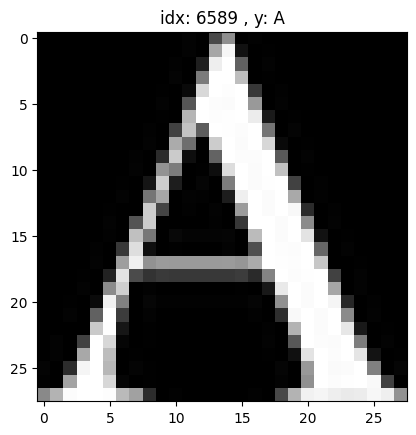

In [72]:
rand_i = np.random.randint(0, x.shape[0])

plt.title( f'idx: {rand_i} , y: {"ABCDEFGHIJ"[ int(y[rand_i]) ]}' )
plt.imshow( x[rand_i, :, :, 0], cmap='gray' )
plt.show()

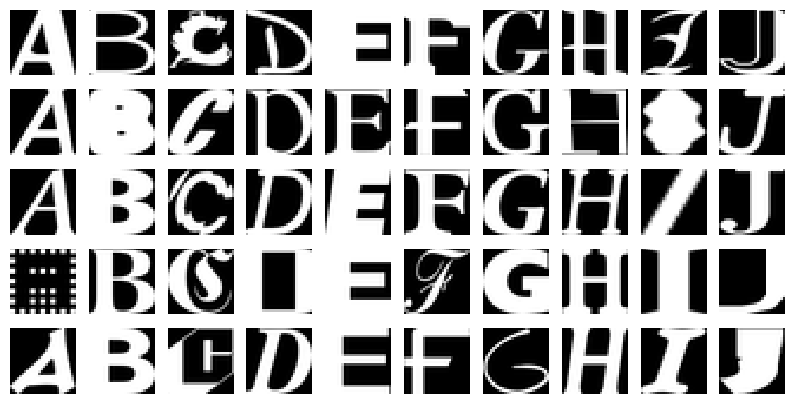

In [73]:
rows = 5
fig, axes = plt.subplots(rows, classes, figsize=(classes,rows))

for letter_id in range(classes) :
    letters = x[y==letter_id]      # 0부터 9까지 각 숫자에 맞는 array가 letters에 들어간다.
    letters_len = len(letters)

    for row_i in range(rows) :
        axe = axes[row_i, letter_id]
        axe.imshow( letters[np.random.randint(letters_len)], cmap='gray', interpolation='none')
        axe.axis('off')

## Data Preprocessing

* Data split
    - training set : test set = 8 : 2
    - training set : validation set = 8 : 2
    - 재현을 위한 난수 고정 : 2024

In [74]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.2,random_state=2024)

x_train.shape,x_test.shape

((14979, 28, 28, 1), (3745, 28, 28, 1))

In [75]:
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=.2,random_state=2024)

x_train.shape,x_val.shape

((11983, 28, 28, 1), (2996, 28, 28, 1))

* Scaling

    - min-max scaling

In [76]:
max,min =x_train.max(),x_train.min()

x_train=(x_train-min)/(max-min)
x_test=(x_test-min)/(max-min)

x_train.shape, x_test.shape

((11983, 28, 28, 1), (3745, 28, 28, 1))

* One-hot encoding

In [77]:
from keras.utils import to_categorical

classes=len(np.unique(y_train))

y_train=to_categorical(y_train,classes)
y_test=to_categorical(y_test,classes)

y_train.shape, y_test.shape

((11983, 10), (3745, 10))

* Data shape 재확인

In [78]:
x_train.shape, y_train.shape

((11983, 28, 28, 1), (11983, 10))

## **Image Precessing&Augmentation Layers**

In [79]:
from tensorflow import keras

aug_layers = [keras.layers.RandomRotation(factor=(-0.3,0.3)),
              keras.layers.RandomTranslation(height_factor=(-0.3,0.3), width_factor=(-0.3,0.3)),
              keras.layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2)),
              keras.layers.RandomFlip(mode='horizontal_and_vertical')
              ]

In [80]:
def image_augmentation(images):
    for layer in aug_layers:
        images = layer(images)
    return images

In [81]:
aug_imgs = image_augmentation(x_train[0])

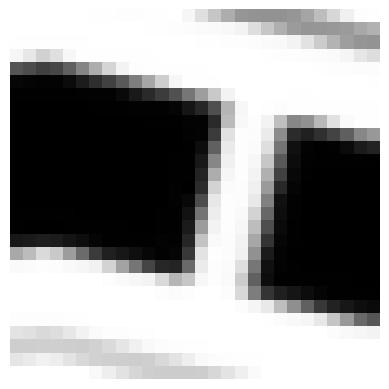

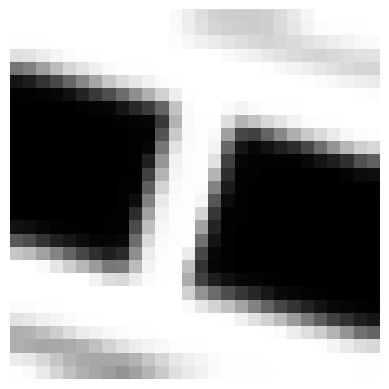

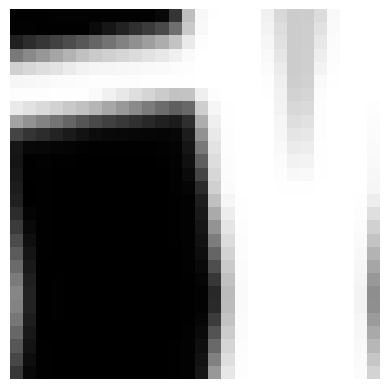

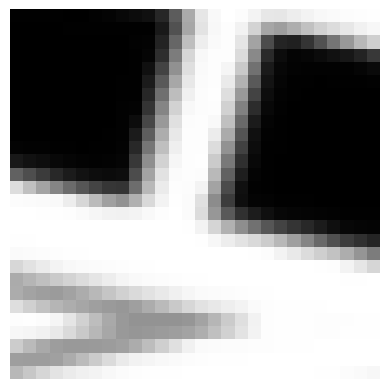

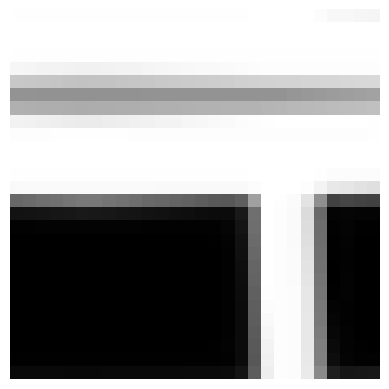

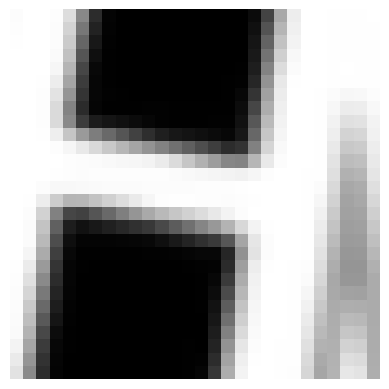

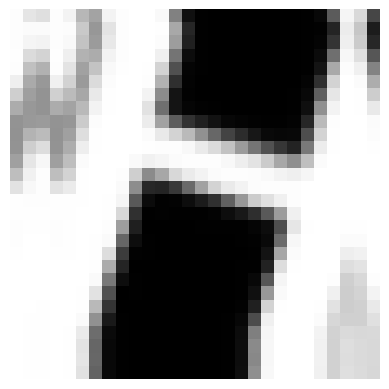

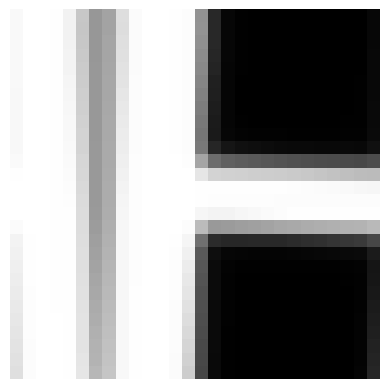

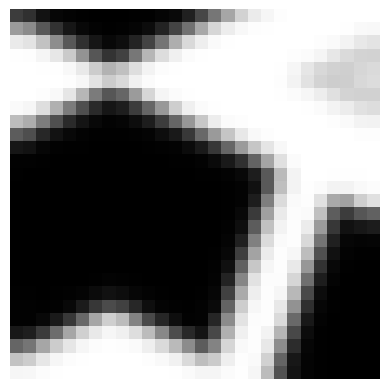

In [82]:
rand_n = np.random.randint(0, 11982)

for i in range(9) :
    aug_imgs = image_augmentation(x_train[rand_n])

    plt.imshow( np.array(aug_imgs), cmap='gray' )
    plt.axis('off')
    plt.show()

## Modeling : CNN + **Image Precessing&Augmentation**

- 조건
    1. Sequential API, Functional API 중 택일.
    2. [이 구조를 미니 버전으로 활용해봐도 좋다.](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99DFA5415B38AC752E)
    3. DropOut, BatchNormalization 등의 기능도 같이 활용해보자.
    4. Early Stopping을 사용할 것.

In [83]:
keras.layers.RandomRotation(factor=(-0.3,0.3)),
keras.layers.RandomTranslation(height_factor=(-0.3,0.3), width_factor=(-0.3,0.3)),
keras.layers.RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2)),
keras.layers.RandomFlip(mode='horizontal_and_vertical')

<RandomFlip name=random_flip_2, built=False>

In [84]:
from keras.backend import clear_session

from keras.models import Model,Sequential
from keras.layers import Input,Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPool2D,RandomRotation,RandomTranslation,RandomZoom,RandomFlip

In [85]:
clear_session()

il=Input(shape=(28,28,1))
#keras에서 제공하는 Augmentation Layer는 Input 바로 아래에 있어야 합니다
hl=RandomRotation(factor=(-0.3,0.3))(il)
hl=RandomTranslation(height_factor=(-0.3,0.3), width_factor=(-0.3,0.3))(hl)
hl=RandomZoom(height_factor=(-0.2,0.2), width_factor=(-0.2,0.2))(hl)
hl=RandomFlip(mode='horizontal_and_vertical')(hl)

hl=Conv2D(64,3,1,'same',activation='relu')(hl)
hl=Conv2D(64,3,1,'same',activation='relu')(hl)
hl=MaxPool2D(2,2)(hl)
hl=Conv2D(128,3,1,'same',activation='relu')(hl)
hl=Conv2D(128,3,1,'same',activation='relu')(hl)
hl=MaxPool2D(2,2)(hl)

hl=Flatten()(hl)
hl=Dense(1024,activation='relu')(hl)
ol=Dense(10,activation='softmax')(hl)

model=Model(il,ol)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 28, 28, 1)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       6,423,552 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,692,810 (25.53 MB)

 Trainable params: 6,692,810 (25.53 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

* Early Stopping

In [100]:
from keras.callbacks import EarlyStopping

es=EarlyStopping(patience=3,
                 verbose=1,
                 restore_best_weights=True)

* .fit( )

In [101]:
model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=3,verbose=1,callbacks=[es])

Epoch 1/3
374/375 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6242 - loss: 1.1177

ValueError: Cannot take the length of shape with unknown rank.

* .evaluate( )

In [89]:
model.evaluate(x_test,y_test)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6193 - loss: 1.1865


[1.23605215549469, 0.5978637933731079]

* .predict( )

In [90]:
y_pred=model.predict(x_test)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [91]:
# 원핫 인코딩 한 것을 다시 묶어주는 코드
# 평가 지표 및 실제 데이터 확인을 위해 필요

y_pred_arg = np.argmax(y_pred, axis=1)
test_y_arg = np.argmax(y_pred, axis=1)

* 평가 지표

In [92]:
from sklearn.metrics import accuracy_score, classification_report

In [93]:
accuracy_score(test_y_arg, y_pred_arg)

1.0

In [94]:
print( classification_report(test_y_arg, y_pred_arg) )

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       429
           1       1.00      1.00      1.00       358
           2       1.00      1.00      1.00       212
           3       1.00      1.00      1.00       550
           4       1.00      1.00      1.00       535
           5       1.00      1.00      1.00       174
           6       1.00      1.00      1.00       578
           7       1.00      1.00      1.00       303
           8       1.00      1.00      1.00       301
           9       1.00      1.00      1.00       305

    accuracy                           1.00      3745
   macro avg       1.00      1.00      1.00      3745
weighted avg       1.00      1.00      1.00      3745



## Visualization

* 실제 데이터 확인

idx = 2286
해당 인덱스의 이미지는 H
모델의 예측 : H
모델의 클래스별 확률 : 
-------------------
A 9.0
B 0.0
C 2.0
D 1.0
E 0.0
F 0.0
G 0.0
H 46.0
I 27.0
J 11.0
정답


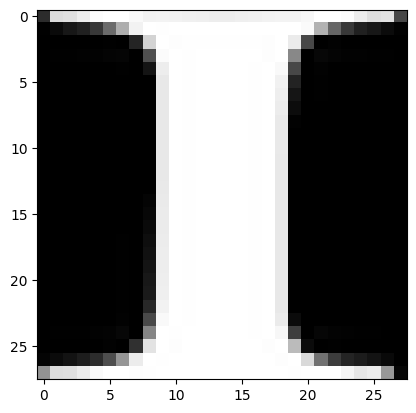

In [95]:
letters_str = "ABCDEFGHIJ"

rand_idx = np.random.randint(0, len(y_pred_arg))
test_idx = test_y_arg[rand_idx]
pred_idx = y_pred_arg[rand_idx]
class_prob = np.floor( y_pred[rand_idx]*100 )

print(f'idx = {rand_idx}')
print(f'해당 인덱스의 이미지는 {letters_str[test_idx]}')
print(f'모델의 예측 : {letters_str[pred_idx]}')
print(f'모델의 클래스별 확률 : ')
print('-------------------')
for idx, val in enumerate(letters_str) :
    print(val, class_prob[idx])
print('=================================================')

if test_y_arg[rand_idx] == y_pred_arg[rand_idx] :
    print('정답')
else :
    print('땡')

plt.imshow(x_test[rand_idx], cmap='gray')
plt.show()

* 틀린 이미지만 확인해보기

In [96]:
len(y_test)

3745

In [97]:
temp = (test_y_arg == y_pred_arg)
false_idx = np.where(temp==False)[0]
false_len = len(false_idx)
false_len

0

In [98]:
letters_str = "ABCDEFGHIJ"

rand_idx = false_idx[np.random.randint(0, false_len)]
test_idx = test_y_arg[rand_idx]
pred_idx = y_pred_arg[rand_idx]
class_prob = np.floor( y_pred[rand_idx]*100 )

print(f'idx = {rand_idx}')
print(f'해당 인덱스의 이미지는 {letters_str[test_idx]}')
print(f'모델의 예측 : {letters_str[pred_idx]}')
print(f'모델의 클래스별 확률 : ')
print('-------------------')
for idx, val in enumerate(letters_str) :
    print(val, class_prob[idx])
print('=================================================')

if test_y_arg[rand_idx] == y_pred_arg[rand_idx] :
    print('정답')
else :
    print('땡')

plt.imshow(x_test[rand_idx], cmap='gray')
plt.show()

ValueError: high <= 0